In this Jupyter notebook, we will see how to produce a model of the planetary transit in a light curve using the parameters from the literature. This is a preliminary passage to the fit of the model to the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pickle

After importing the usual packages, we load the TASTE and TESS light curves we have selected during the previous analysis.

## Sector 80


In [14]:
taste_bjd_tdb = pickle.load(open('../TASTE_analysis/taste_bjdtdb.p', 'rb'))
differential_allref_normalized = pickle.load(open('../TASTE_analysis/differential_ap06_allref_normalized.p', 'rb'))
differential_allref_normalized_error = pickle.load(open('../TASTE_analysis/differential_ap06_allref_normalized_error.p', 'rb'))

differential_allref = pickle.load(open('../TASTE_analysis/differential_ap06_allref.p', 'rb'))
differential_allref_error = pickle.load(open('../TASTE_analysis/differential_ap06_allref_error.p', 'rb'))

#normalized_differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/normalized_differential_ap11_ref01.p', 'rb'))
#differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/differential_ap11_ref01.p', 'rb'))



tess_sector80_dict = pickle.load(open('flatten_sector80_dictionary.p' , 'rb'))

tess_bjd_tdb = pickle.load(open('../TASTE_analysis/taste_bjdtdb.p', 'rb'))
tess_normalized_flux = tess_sector80_dict['selected_flux']
tess_normalized_flux_error = tess_sector80_dict['selected_flux_error']

### batman
(Bad-Ass Transit Model cAlculatioN) is a Python package for easy and fast calculation of transit light curves.

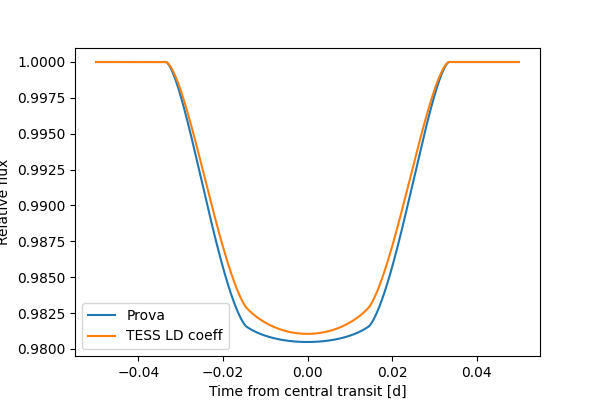

In [6]:
# Check batman 2.4.6. documentation
import batman

params = batman.TransitParams()

params.t0 = 0.                          #time of inferior conjunction
#params.t0 =  2459768.65359               # ExoFOP TOIs (TESS Project) 
#params.t0 =  2455230.9902                # ExoFOP Confirmed Planets (Exoplanet Archive) 

params.per = 1.4013795                     #orbital period
params.rp = 0.14                      #planet radius (in units of stellar radii)
params.a = 5.61                       #semi-major axis (in units of stellar radii)
params.inc = 82.0                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(-0.05, 0.05, 1000)   # times at which calculate light curve
m = batman.TransitModel(params, t)   # initializes model
flux = m.light_curve(params)

params.u = [0.49, 0.11] 
flux_new = m.light_curve(params)

plt.figure(figsize=(6,4))
plt.plot(t, flux, label='Prova')
plt.plot(t, flux_new, label='TESS LD coeff')
plt.xlabel('Time from central transit [d]')
plt.ylabel('Relative flux')
plt.legend()
plt.show()

### Limb darkening coefficients

The shape of the transit model does not closely follow our data during the central part of the transit, with the data having a more significant curvature than the model in the central part of the transit. This effect is due to improper limb darkening parameters.

Since the limb darkening parameters depend on the properties of the stellar atmosphere (parametrized through the effective temperature, surface gravity, and metallicity) and the transmissivity of the filter used to gather the data, their derivation is a challenging task.

In our analysis, we are going to use the Python Limb Darkening Toolkit (ldtk), a Python toolkit for calculating stellar limb darkening coefficients for arbitrary passbands using the stellar spectrum model library by Husser et al. (2013). This tool provides access to the Spanish Virtual Observatory (SVO) Filter Profile Service (FPS). to retrieve the passband of the filters used to gather our data, thus further facilitating our job. 

In [7]:
from ldtk import SVOFilter, LDPSetCreator
SVOFilter.shortcuts

{'kepler': 'Kepler/Kepler.k',
 'tess': 'TESS/TESS.Red',
 'sdss_g': 'SLOAN/SDSS.g',
 'sdss_r': 'SLOAN/SDSS.r',
 'sdss_i': 'SLOAN/SDSS.i',
 'sdss_z': 'SLOAN/SDSS.z'}

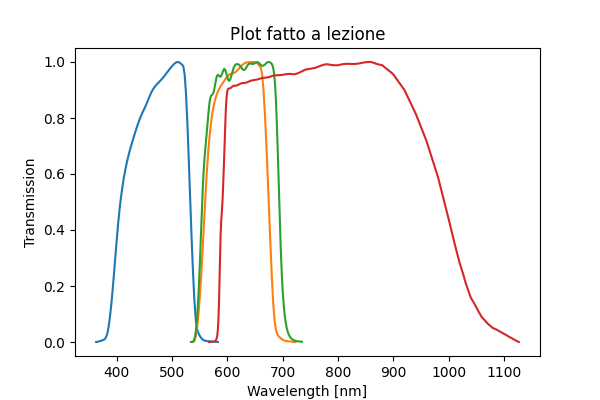

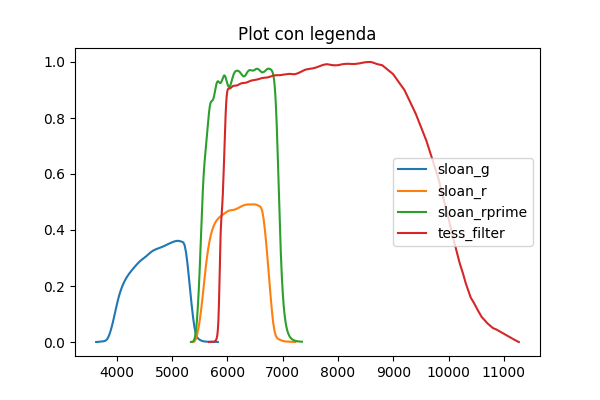

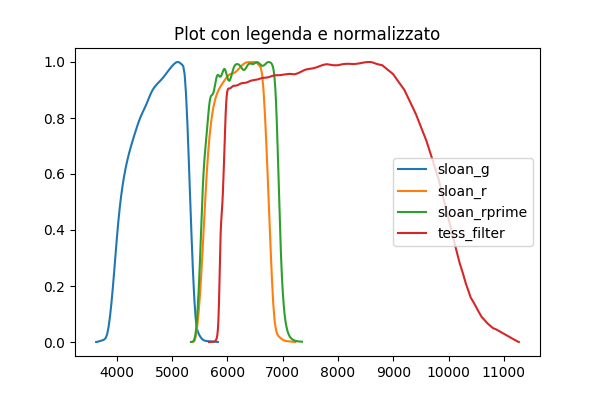

In [8]:
sloan_g = SVOFilter('sdss_g')
sloan_r = SVOFilter('sdss_r')
sloan_rprime = SVOFilter('SLOAN/SDSS.rprime_filter')
tess_filter = SVOFilter('tess')

#print(sloan_g.__dict__)


fig, ax = plt.subplots(figsize=(6,4))
sloan_g.plot(ax=ax)
sloan_r.plot(ax=ax)
sloan_rprime.plot(ax=ax)
tess_filter.plot(ax=ax)
plt.title('Plot fatto a lezione')
plt.show()



fig, ax = plt.subplots(figsize=(6,4))
ax.plot(sloan_g._svo_data['Wavelength'], sloan_g._svo_data['Transmission'], label='sloan_g')  
ax.plot(sloan_r._svo_data['Wavelength'], sloan_r._svo_data['Transmission'], label='sloan_r')  
ax.plot(sloan_rprime._svo_data['Wavelength'], sloan_rprime._svo_data['Transmission'], label='sloan_rprime')  
ax.plot(tess_filter._svo_data['Wavelength'], tess_filter._svo_data['Transmission'], label='tess_filter')  
ax.legend()  
plt.title('Plot con legenda')
plt.show()


fig, ax = plt.subplots(figsize=(6,4))
# Normalizzazione rispetto al valore massimo
ax.plot(sloan_g._svo_data['Wavelength'], sloan_g._svo_data['Transmission'] / max(sloan_g._svo_data['Transmission']), label='sloan_g')  
ax.plot(sloan_r._svo_data['Wavelength'], sloan_r._svo_data['Transmission'] / max(sloan_r._svo_data['Transmission']), label='sloan_r')  
ax.plot(sloan_rprime._svo_data['Wavelength'], sloan_rprime._svo_data['Transmission'] / max(sloan_rprime._svo_data['Transmission']), label='sloan_rprime')  
ax.plot(tess_filter._svo_data['Wavelength'], tess_filter._svo_data['Transmission'] / max(tess_filter._svo_data['Transmission']), label='tess_filter')  
ax.legend()  
plt.title('Plot con legenda e normalizzato')
plt.show()


In [9]:
# TASTE filter: sloan_r , TESS filter: tess_filter

filters = [sloan_r, tess_filter]
sc = LDPSetCreator(teff=(4984, 124), logg=(4.41, 0.085), z=(0.02, 0.13), filters=filters) # stellar parameters: Teff, Grav, metall
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(100)

ps.set_uncertainty_multiplier(10)
qm, qe = ps.coeffs_qd(do_mc = True, n_mc_samples=10000)
chains = np.array(ps._samples['qd'])

In [10]:
print(np.shape(chains))

(2, 10000, 2)


Sloan r LD coefficients u1 = 0.6230 \pm 0.0316  u2 = 0.0912 \pm 0.0758
TESS LD coefficients   : u1 = 0.49 \pm 0.02    u2 = 0.10 \pm 0.06


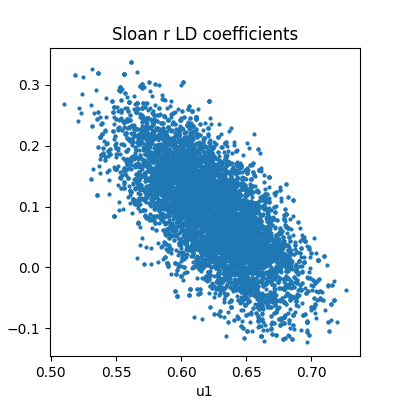

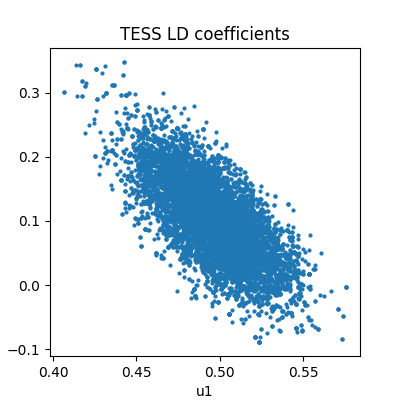

In [11]:
u1_sloan_r_chains = chains[0,:,0]
u2_sloan_r_chains = chains[0,:,1]

u1_tess_chains = chains[1,:,0]
u2_tess_chains = chains[1,:,1]

print('Sloan r LD coefficients u1 = {0:.4f} \pm {1:.4f}  u2 = {2:.4f} \pm {3:.4f}'.format(
    np.median(u1_sloan_r_chains), np.std(u1_sloan_r_chains),
    np.median(u2_sloan_r_chains), np.std(u2_sloan_r_chains),))

print('TESS LD coefficients   : u1 = {0:4.2f} \pm {1:4.2f}    u2 = {2:4.2f} \pm {3:4.2f}'.format(
    np.mean(u1_tess_chains), np.std(u1_tess_chains),  
    np.mean(u2_tess_chains), np.std(u2_tess_chains),
))

plt.figure(figsize=(4,4))
plt.title('Sloan r LD coefficients')
plt.scatter(u1_sloan_r_chains, u2_sloan_r_chains, s=4)
plt.xlabel('u1')
plt.ylabel('u2')
plt.show()

plt.figure(figsize=(4,4))
plt.title('TESS LD coefficients')
plt.scatter(u1_tess_chains, u2_tess_chains, s=4)
plt.xlabel('u1')
plt.ylabel('u2')
plt.show()


The package provides error estimates for the coefficients. Still, those are computed by simply varying the stellar parameters according to their associated error without considering the systematic errors due to the specific stellar atmosphere models used for the analysis. In other words, employing different stellar models may produce a different set of coefficients, and this difference is not currently included in the estimate of the coefficients. We will deal with this problem in two ways:
- we will artificially enlarge the associated errors to the coefficient
- we will let the optimization tool free to explore different values for the coefficients We will see later on how to implement these two solutions.

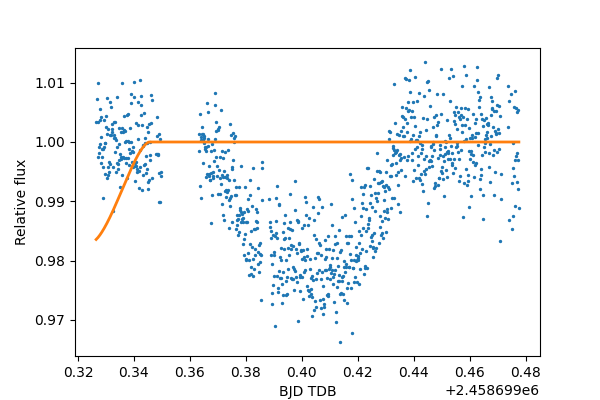

ValueError: x and y must be the same size

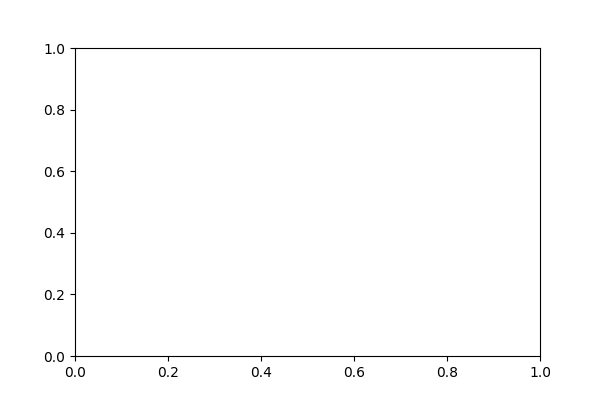

In [15]:
#params = batman.TransitParams()
#params.t0 =  2459500.53574                      #time of inferior conjunction
#params.per = 1.40138                      #orbital period
#params.rp = 0.0764                      #planet radius (in units of stellar radii)
#params.a = 14.6                        #semi-major axis (in units of stellar radii)
#params.inc = 82                     #orbital inclination (in degrees)
#params.ecc = 0.                      #eccentricity
#params.w = 90.                       #longitude of periastron (in degrees)


###TASTE LD
params.u = [0.6236 , 0.0930]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_model_flux = m_taste.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_allref_normalized, s=2)

plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()


###TESS LD
params.t0 =  2459768.65359

params.u = [0.49, 0.11]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_model_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()



params.t0 =  2455230.9902        # ExoFOP Confirmed Planets (Exoplanet Archive) 

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.axvline(0, color='red')
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()



params.t0 =  2459768.65359      # ExoFOP TOIs (TESS Project) 
# ^-- questo è il migliore tra i due

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.axvline(0, color='red')
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()


## Sector 79

In [8]:
taste_bjd_tdb = pickle.load(open('../TASTE_analysis/taste_bjdtdb.p', 'rb'))
#differential_allref_normalized = pickle.load(open('differential_ap
#differential_allref_normalized_error = pickle.load(

#differential_allref = pickle.load(
#differential_allref_error = pickle.load(

normalized_differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/normalized_differential_ap11_ref01.p', 'rb'))

differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/differential_ap11_ref01.p', 'rb'))



tess_sector79_dict = pickle.load(open('flatten_sector79_dictionary.p' , 'rb'))

tess_bjd_tdb = tess_sector79_dict['time']
tess_normalized_flux = tess_sector79_dict['selected_flux']
tess_normalized_flux_error = tess_sector79_dict['selected_flux_error']

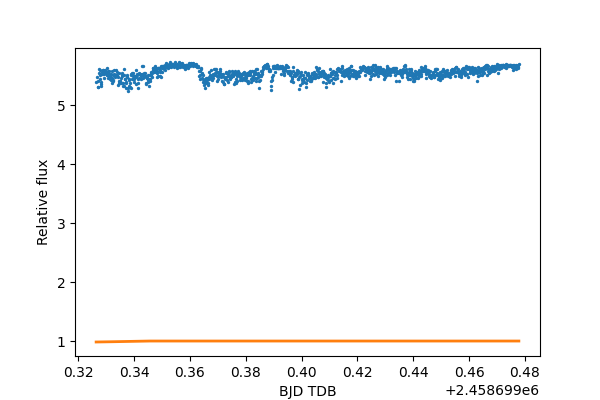

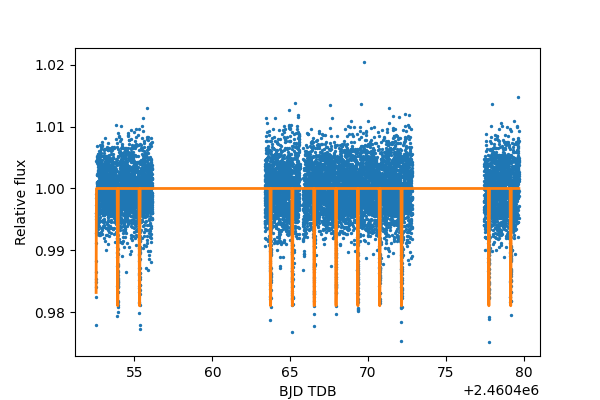

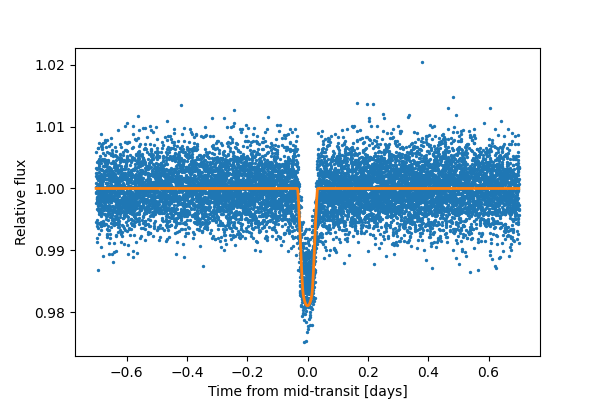

In [9]:
###TASTE LD
params.u = [0.6236 , 0.0930]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_model_flux = m_taste.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, normalized_differential_ap11_ref01, s=2)

plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

###TESS LD
params.t0 =  2459768.65359
params.u = [0.49, 0.11]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_model_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
#plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()


## Sector 53

In [10]:
taste_bjd_tdb = pickle.load(open('../TASTE_analysis/taste_bjdtdb.p', 'rb'))
#differential_allref_normalized = pickle.load(open('differential_ap
#differential_allref_normalized_error = pickle.load(

#differential_allref = pickle.load(
#differential_allref_error = pickle.load(

normalized_differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/normalized_differential_ap11_ref01.p', 'rb'))

differential_ap11_ref01 = pickle.load(open('../TASTE_analysis/differential_ap11_ref01.p', 'rb'))



tess_sector53_dict = pickle.load(open('flatten_sector53_dictionary.p' , 'rb'))

tess_bjd_tdb = tess_sector53_dict['time']
tess_normalized_flux = tess_sector53_dict['selected_flux']
tess_normalized_flux_error = tess_sector53_dict['selected_flux_error']

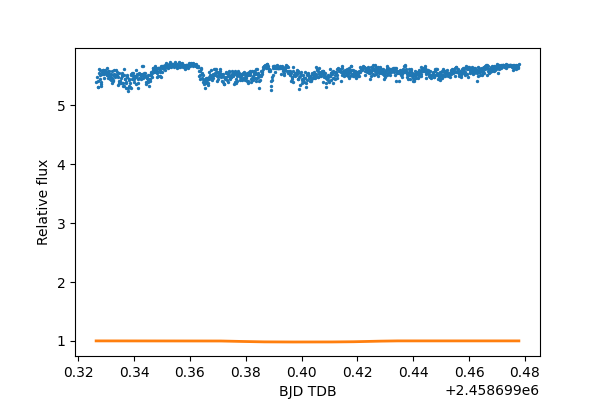

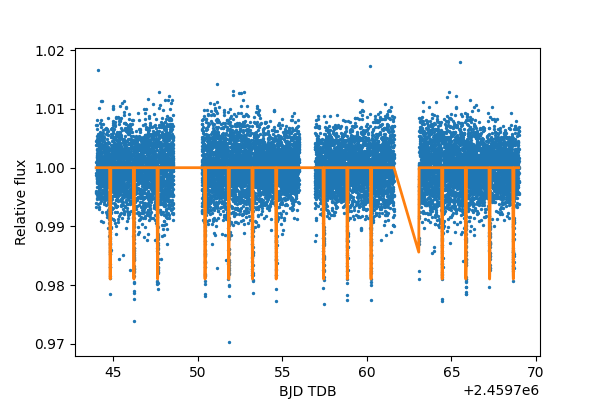

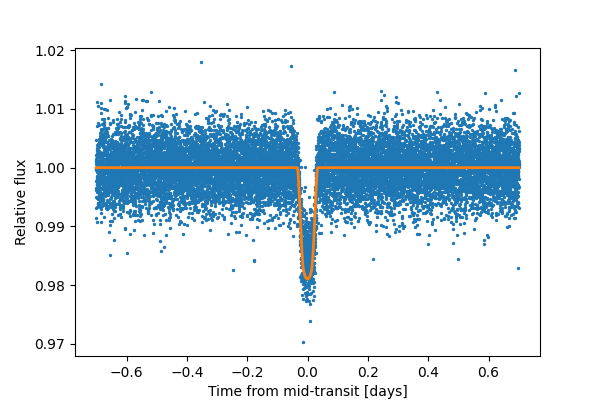

In [11]:
###TASTE LD
params.t0 =  2459768.65359
params.u = [0.6236 , 0.0930]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_model_flux = m_taste.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, normalized_differential_ap11_ref01, s=2)

plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

###TESS LD
params.u = [0.49, 0.11]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_model_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
#plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()
